# Gaussian Process Taste-test

The scikit-learn package has a nice Gaussian Process demo. First we run that, and then try to do the same thing by-hand with numpy/scipy.

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid')

## Make Some Data

In [2]:
def f(x):
    """The function to predict."""
    return x * np.sin(x)

def make_data(N, rseed=1):
    np.random.seed(rseed)

    # Create some observations with noise
    X = np.linspace(0.1, 9.9, N)
    X = np.atleast_2d(X).T

    y = f(X).ravel()
    dy = 1.0 + 2.0 * np.random.random(y.shape)
    noise = np.random.normal(0, dy)
    y += noise
    
    return X, y, dy

X, y, dy = make_data(20)

## Gaussian Process Regression with Scikit-Learn

Example adapted from [Scikit-learn's Examples](http://scikit-learn.org/dev/auto_examples/gaussian_process/plot_gpr_noisy_targets.html)

In [3]:
# Get the master version of scikit-learn; new GP code isn't in release
# This needs to compile things, so it will take a while...
# Uncomment the following:

# !pip install git+git://github.com/scikit-learn/scikit-learn.git

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF as SquaredExponential
from sklearn.gaussian_process.kernels import ConstantKernel as Amplitude

# Instanciate a Gaussian Process model
kernel = Amplitude(1.0, (1E-3, 1E3)) * SquaredExponential(10, (1e-2, 1e2))

# Instantiate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=(dy / y)**2,  # fractional errors in data
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

GaussianProcessRegressor(alpha=array([  7.70531e-01,   1.09840e+00,   1.37917e+00,   4.70772e+01,
         4.89291e-01,   3.94518e-01,   6.67193e-01,   7.17824e+02,
         7.15887e-01,   3.15988e-01,   4.19417e-01,   2.85442e-01,
         1.11228e+02,   1.14522e+01,   3.06663e-02,   6.65079e-02,
         9.14528e-02,   3.03521e-01,   6.57404e+00,   5.97961e-02]),
             copy_X_train=True, kernel=1**2 * RBF(length_scale=10),
             n_restarts_optimizer=10, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [5]:
gp.kernel_

3.82**2 * RBF(length_scale=0.564)

In [6]:
# note: gp.kernel is the initial kernel
#       gp.kernel_ (with an underscore) is the fitted kernel
gp.kernel_.get_params()

{'k1': 3.82**2,
 'k1__constant_value': 14.60773959976696,
 'k1__constant_value_bounds': (0.001, 1000.0),
 'k2': RBF(length_scale=0.564),
 'k2__length_scale': 0.56403669173527948,
 'k2__length_scale_bounds': (0.01, 100.0)}

In [7]:
# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x_pred = np.atleast_2d(np.linspace(0, 10, 1000)).T

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x_pred, return_std=True)

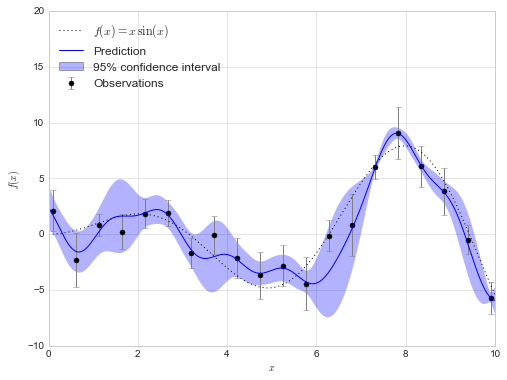

In [8]:
def plot_results(X, y, dy, x_pred, y_pred, sigma):
    fig = plt.figure(figsize=(8, 6))
    plt.plot(x_pred, f(x_pred), 'k:', label=u'$f(x) = x\,\sin(x)$')
    plt.errorbar(X.ravel(), y, dy, fmt='k.', markersize=10, label=u'Observations',
                 ecolor='gray')
    plt.plot(x_pred, y_pred, 'b-', label=u'Prediction')
    plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
             np.concatenate([y_pred - 1.9600 * sigma,
                            (y_pred + 1.9600 * sigma)[::-1]]),
             alpha=.3, fc='b', ec='None', label='95% confidence interval')
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.ylim(-10, 20)
    plt.legend(loc='upper left');
    
plot_results(X, y, dy, x_pred, y_pred, sigma)

## Gaussian Processes by-hand

In [10]:
# Let's use the kernel constructed with scikit-learn (because its parameters are optimized)
# And let's compute the Gaussian process manually using Scipy linalg
import scipy.linalg
KXX = gp.kernel_(X)
A = KXX + np.diag((dy/y)**2.)
L = scipy.linalg.cholesky(A, lower=True)
KXXp = gp.kernel_(x_pred, X)
KXpXp = gp.kernel_(x_pred)
alpha = scipy.linalg.cho_solve((L, True), y)
y_pred = np.dot(KXXp, alpha) + np.mean(y, axis=0)
v = scipy.linalg.cho_solve((L, True), KXXp.T)
y_pred_fullcov = KXpXp - KXXp.dot(v)
sigma = np.sqrt(np.diag(y_pred_fullcov))

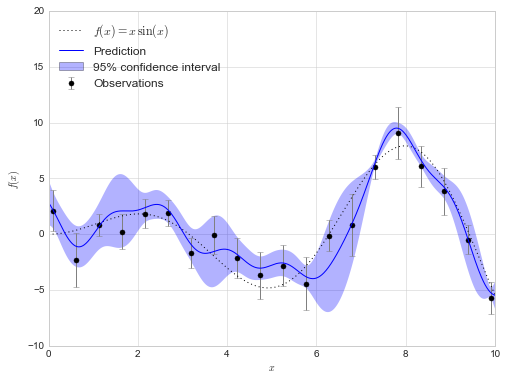

In [11]:
plot_results(X, y, dy, x_pred, y_pred, sigma) 